In [ ]:
%%bash
python backup-notebook.py /home/ubuntu/py-lb-nbody-example-generator/

In [36]:
%%bash
pip install jupyterthemes



### Drobpox file storage

In [1]:
def load_dropbox_token(directory='.'):
    '''
    Should explicitly add dropbox.token into the project
    because .gitignore exclude those files from github
    '''
    import os
    with open(os.path.join(directory, 'dropbox.token'), 'r') as token:
        dbx_token = token.read()
    return dbx_token[:len(dbx_token)-1]

TOKEN=load_dropbox_token('~/Dropbox/projects/python/nbody-example-generator')

PICTURE_REPOSITORY='projects/python/nbody-example-generator/images'
import dropbox, os, sys
from dropbox.files import WriteMode
from dropbox.exceptions import ApiError, AuthError
def exists_on_dbx(dbx, path):
    try:
        dbx.files_get_metadata(path)
        return True
    except:
        return False
    
def yesno(message, default=False, force=False):
    """Handy helper function to ask a yes/no question.
    Command line arguments --yes or --no force the answer;
    --default to force the default answer.
    Otherwise a blank line returns the default, and answering
    y/yes or n/no returns True or False.
    Retry on unrecognized answer.
    Special answers:
    - q or quit exits the program
    - p or pdb invokes the debugger
    """
    if force:
        return True
    
    if default:
        message += '? [Y/n] '
    else:
        message += '? [N/y] '
    
    while True:
        answer = raw_input(message).strip().lower()
        if not answer:
            return default
        if answer in ('y', 'yes'):
            return True
        if answer in ('n', 'no'):
            return False
        if answer in ('q', 'quit'):
            print('Exit')
            raise SystemExit(0)
        if answer in ('p', 'pdb'):
            import pdb
            pdb.set_trace()
        print('Please answer YES or NO.')
    
def sync(dbx, folder, BACKUPPATH='/backup/', ask_permission=True):
    import os
    files = filter(lambda f: f not in ['.', '..'], os.listdir(folder))
    for f in files:
        backup(dbx, os.path.join(folder, f), force=(not ask_permission))
    
# Uploads contents of LOCALFILE to Dropbox
def backup(dbx, LOCALFILE, BACKUPPATH='/backup/', force=False):
    BACKUPPATH=os.path.join(BACKUPPATH,LOCALFILE)
    with open(LOCALFILE, 'rb') as f:
        # We use WriteMode=overwrite to make sure that the settings in the file
        # are changed on upload
        if exists_on_dbx(dbx, BACKUPPATH):
            if not yesno("Are you sure you want to overwrite %s"%BACKUPPATH, force=force):
                return False
        print("Uploading " + LOCALFILE + " to Dropbox as " + BACKUPPATH + "...")    
        try:
            dbx.files_upload(f.read(), BACKUPPATH, mode=WriteMode('overwrite'))
        except ApiError as err:
            # This checks for the specific error where a user doesn't have
            # enough Dropbox space quota to upload this file
            if (err.error.is_path() and
                    err.error.get_path().error.is_insufficient_space()):
                sys.exit("ERROR: Cannot back up; insufficient space.")
            elif err.user_message_text:
                print(err.user_message_text)
                sys.exit()
            else:
                print(err)
                sys.exit()
dbx = dropbox.Dropbox(TOKEN)
try:
    dbx.users_get_current_account()
except AuthError as err:
    sys.exit("ERROR: Invalid access token; try re-generating an "
        "access token from the app console on the web.")
backup(dbx, 'nbody-example-generator-notebook.ipynb', force=True)

IOError: [Errno 2] No such file or directory: '~/Dropbox/projects/python/nbody-example-generator/dropbox.token'

In [ ]:
%matplotlib inline
import numpy
import itertools
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pprint import pprint
from math import sqrt
cutoff=2.5*10**-2

def points_to_adjlist(x,y, cutoff_radius):
    adjlist = []
    for i in range(len(x)):
        part_interactions = [0] * len(x)
        for j in range(0, len(x)):
            if particle_distance( (x[i], y[i]), (x[j], y[j]) ) <= cutoff_radius:
                part_interactions[j] = 1
        adjlist.append(part_interactions)
    return adjlist

def points_to_edgelist(x, y, cutoff_radius):
    edgelist = []
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if particle_distance( (x[i], y[i]), (x[j], y[j]) ) <= cutoff_radius:
                edgelist.append((i, j))
    return edgelist

def points_to_graph(x, y, cutoff_radius):
    import networkx as nx
    G = nx.Graph()
    points = zip(x,y)
    for i in range(len(points)):
        G.add_node(i, position=points[i])
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if particle_distance( (x[i], y[i]), (x[j], y[j]) ) <= cutoff_radius:
                G.add_edge(i, j)
    return G    

def particle_distance(p1, p2):
    return sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_particles(x, y, **kwargs):
    fig = kwargs.get('fig', plt.figure())
    cutoff = kwargs.get('cutoff_radius', 2.5*10**-2)
    if kwargs.get('interaction', True)==True:
        for i in range(len(x)):
            for j in range(i, len(x)):
                if particle_distance( (x[i], y[i]), (x[j], y[j]) ) <= cutoff:
                    plt.plot([x[i],x[j]], [y[i],y[j]], c='black', linestyle='--', linewidth=0.1)
    
    colors = kwargs.get('colors', {i: 'red' for i in range(len(x))})
    
    for xv,yv,cl in zip(x,y,colors.values()):
        plt.scatter(x=xv, y=yv, c=cl, s=5)
    
    if kwargs.get('cutoff', True) == True:
        numpy.random.seed()
        show_cutoff_particle = kwargs.get('cutoffid',int(numpy.random.uniform(0, 20)))
        plt.text(x[show_cutoff_particle]+cutoff, y[show_cutoff_particle]-cutoff, 'cut off')
        circ = plt.Circle((x[show_cutoff_particle], y[show_cutoff_particle]), radius=cutoff, color='g', linestyle='--', fill=False)
        ax = fig.add_subplot(1, 1, 1)
        ax.add_patch(circ)
        
    plt.axis('equal')
    plt.title('Simulation space')
    plt.xlabel('Particle position x')
    plt.ylabel('Particle position y')
    
    if kwargs.get('save', False):
        pp = PdfPages('images/'+kwargs.get('name'))
        pp.savefig()
        pp.close()


# Uniform distribution of 500 particles in a 1-by-1 space
Create a picture of 500 particles uniformly distributed in space
and interacting via a short range interaction (e.g., Lennard-Jones interactions)


In [ ]:
domain = [0,1]
numpy.random.seed(6)
uniform = lambda p,x :numpy.random.uniform(p, x)

nb = 400

x = [uniform(0.0, 1.0) for _ in range(nb)]
y = [uniform(0.0, 1.0) for _ in range(nb)]

plot_particles(x,y, interaction=True, cutoff=True, save=True, name='example_shortrange-nbody_uniform.pdf')
plot_particles(x,y, interaction=True, cutoff=True, cutoff_radius=0.025, save=True, name='example_longrange-nbody_uniform.pdf')
backup(dbx, 'example_shortrange-nbody_uniform.pdf')
backup(dbx, 'example_longrange-nbody_uniform.pdf')



## Non-uniform particle distribution in a 1-by-1 space
Non-uniform distribution (i.e., four gaussian (x&y) distributions), 
the interactions are illustrated by dashed lines and the cutoff radius is highlighted in green. 

In [ ]:
domain = [0,1]
numpy.random.seed(6)
normal = lambda p,x :numpy.random.normal(p, x)

uni = lambda: int(numpy.random.uniform(30,70))

nb = uni()
x = [normal(0.25, 0.035) for _ in range(nb)]
y = [normal(0.25, 0.035) for _ in range(nb)]

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.2, 0.025) for _ in range(nb)])

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.4, 0.02) for _ in range(nb)])

nb = uni()
x.extend([normal(0.28, 0.04) for _ in range(nb)])
y.extend([normal(0.4, 0.04) for _ in range(nb)])

rest = 300-len(x)
x.extend([uniform(0.1, 0.7) for _ in range(rest)])
y.extend([uniform(0.1, 0.7) for _ in range(rest)])

plot_particles(x,y, interaction=True, cutoff=True, save=True, name='example_nbody_non_uniform.pdf')
backup(dbx, 'images/example_nbody_non_uniform.pdf')

print 'Total number of particle generated: ', len(x)


In [ ]:
domain = [0,1]
numpy.random.seed(6)

normal = lambda p,x :numpy.random.normal(p, x)
uniform= lambda p,x :numpy.random.uniform(p, x)

uni = lambda: int(numpy.random.uniform(30,70))

nb = uni()
x = [normal(0.25, 0.035) for _ in range(nb)]
y = [normal(0.25, 0.035) for _ in range(nb)]

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.2, 0.025) for _ in range(nb)])

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.4, 0.02) for _ in range(nb)])

nb = uni()
x.extend([normal(0.28, 0.04) for _ in range(nb)])
y.extend([normal(0.4, 0.04) for _ in range(nb)])

rest = 500-len(x)
x.extend([uniform(0.1, 0.7) for _ in range(rest)])
y.extend([uniform(0.1, 0.7) for _ in range(rest)])

plot_particles(x,y, interaction=True, cutoff=True, cutoff_radius=0.025, cutoffid=300, save=True, name='example_nbody_non_uniform_clean.pdf')

print 'Total number of particle generated: ', len(x)

In [ ]:
domain = [0,1]
numpy.random.seed(6)

normal = lambda p,x :numpy.random.normal(p, x)
uniform= lambda p,x :numpy.random.uniform(p, x)

uni = lambda: 50#int(numpy.random.uniform(30,70))

nb = uni()
x = [normal(0.25, 0.035) for _ in range(nb)]
y = [normal(0.25, 0.035) for _ in range(nb)]

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.2, 0.025) for _ in range(nb)])

nb = uni()
x.extend([normal(0.55, 0.02) for _ in range(nb)])
y.extend([normal(0.4, 0.02) for _ in range(nb)])

nb = uni()
x.extend([normal(0.28, 0.04) for _ in range(nb)])
y.extend([normal(0.4, 0.04) for _ in range(nb)])

rest = 500-len(x)
#x.extend([uniform(0.1, 0.7) for _ in range(rest)])
#y.extend([uniform(0.1, 0.7) for _ in range(rest)])

plot_particles(x,y, interaction=False, cutoff=False, cutoffid=300, save=True, name='example_nbody_non_uniform_clean_RCB.pdf')

print 'Total number of particle generated: ', len(x)

### Recursive Coordinate Bisection Algorithm

In [ ]:
def get_median(A, i):
    #divide A into sublists of len 5
    sublists = [A[j:j+5] for j in range(0, len(A), 5)]
    medians = [sorted(sublist)[len(sublist)/2] for sublist in sublists]
    if len(medians) <= 5:
        pivot = sorted(medians)[len(medians)/2]
    else:
        #the pivot is the median of the medians
        pivot = median_of_medians(medians, len(medians)/2)

    #partitioning step
    low = [j for j in A if j < pivot]
    high = [j for j in A if j > pivot]

    k = len(low)
    if i < k:
        return median_of_medians(low,i)
    elif i > k:
        return median_of_medians(high,i-k-1)
    else: #pivot = k
        return pivot

def get_median_with_index(data):
    sorted(data)[len(data)/2]
    
from math import log
log2 = lambda v: log(v)/log(2)

def RCB2D(x, y, part):
    points = zip(x,y)
    
    def bisect(points, dim):
        points.sort(key=lambda el: el[dim])
        median = points[int(len(points)/2)]
        idx_median = int(len(points)/2)
        b1, b2 = (points[:idx_median], points[idx_median:])
        return (median, idx_median, b1, b2)      
    
    d = [points] #start from full domain
    info = []
    for depth in range(int(log2(part))): #for each depth/dim
        dim = (depth) % 2 #dim = x first then y then x ...
        v = [bisect(section, dim) for section in d] #for each subsection...
        d = []
        for i in v:
            d.extend([i[2], i[3]])
        info.extend(v)
    return info #cutting list

In [ ]:
nbPE = 4
p2 = [2**i for i in range(int(log2(nbPE)))]

parent = lambda i: int((i-1)/2)
left   = lambda i: int(2*i + 1)
right  = lambda i: int(2*i + 2)

elem_at_dim = lambda dim: 2**(dim)
which_depth = lambda idx: int(log2(idx+1)) 
which_dim   = lambda idx: which_depth(idx) % 2

def get_cut_start_end_pos(parent_cut, size, parent_dim, left):
    if left==True:
        return (0, parent_cut[parent_dim])
    else:
        return (parent_cut[parent_dim], size)

def plot_cut(where, start_end, dim):
    if dim == 0:
        plt.plot([where, where], [start_end[0], start_end[1]], c='b', linestyle='--', linewidth=0.5)
    else:
        plt.plot([start_end[0], start_end[1]], [where, where], c='b', linestyle='--', linewidth=0.5)

def plotRCB(l, part_info, domain_max):
    ldim = which_depth(l) % 2
    if l == 0:
        se = get_cut_start_end_pos((0,0), domain_max, 0, False)
    else:
        se = get_cut_start_end_pos(part_info[parent(l)][0], domain_max, which_dim(parent(l)), True if l == left(parent(l)) else False)
    linfo = part_info[l]
    
    plot_cut(linfo[0][ldim], se, ldim)
    g = left(l)
    d = right(l)
    if g < len(part_info):
        plot(g, part_info, domain_max)
    if d < len(part_info):
        plot(d, part_info, domain_max)
        
nparticles = 1000
x = [normal(0.25, 0.035) for _ in range(nparticles)]
y = [normal(0.25, 0.035) for _ in range(nparticles)]

part_info = RCB2D(x, y, nbPE)
root = part_info[0]
n = 0
domain = 9

plot_particles(x,y, interaction=False, fig=fig, cutoff=False, save=False, name='example_nbody_non_uniform_clean_RCB.pdf')
plotRCB(0, part_info, max(max(x), max(y)))


### KMeans Clustering

In [ ]:
from sklearn.cluster import KMeans

nb_cluster = 4
kmeans = KMeans(n_clusters=nb_cluster)

X= zip(x,y)

cluster = kmeans.fit_predict(X)
cmap = get_cmap(nb_cluster, 'tab20')

for p in zip(X, cluster):
    plt.scatter(p[0][0], p[0][1], c=cmap(p[1]))

labels = kmeans.labels_

print labels

### METIS Graph Partitioning

In [ ]:
import metis
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
from matplotlib.colors import to_hex 
import matplotlib.patches as mpatch
from random import shuffle
from nxpd import draw

cutoff=2.5*10**-2

normal = lambda p,x :numpy.random.normal(p, x)
uniform= lambda p,x :numpy.random.uniform(p, x)

nbparticles = 25

x = [uniform(0.1, 0.2) for _ in range(nbparticles)]
y = [uniform(0.1, 0.2) for _ in range(nbparticles)]

g = points_to_graph(x, y, cutoff)

nbPE = 4

(edgecuts, parts) = metis.part_graph(g, nbPE)

overlap = {name for name in mcd.CSS4_COLORS if "xkcd:" + name in mcd.XKCD_COLORS}
colors = get_cmap(nbPE, 'tab10') #['red','blue','green']

ncolors = {}
for i, p in enumerate(parts):
    ncolors[i] = colors(p)
    g.node[i]['style'] = 'filled'
    g.node[i]['fillcolor'] = to_hex(colors(p))
    
plot_particles(x, y, colors=ncolors, interaction=False, cutoff=False, save=True, name="images/example_graph_part_metis_colored_without_interactions.pdf")
plot_particles(x, y, colors=ncolors, interaction=True,  cutoff=True, save=True, name="images/example_graph_part_metis_colored_with_interactions.pdf")

backup(dbx, "images/example_graph_part_metis_colored_without_interactions.pdf")
backup(dbx, "images/example_graph_part_metis_colored_with_interactions.pdf")

v = nx.drawing.nx_pydot.write_dot(g, 'images/metis-graph-partitioning.dot') # Requires pydot or pygraphviz
draw(g, show='ipynb')


In [ ]:
#sync(dbx, 'images', ask_permission=False)
backup(dbx, 'nbody-example-generator-notebook.ipynb', force=True)


In [4]:
from numba import jit

@jit
def compute_LJ_scalar(r2, eps, sig2):
    if r2 < 6.25 * sig2:
        if r2 == 0:
            print 'r2 equals zero'
        z = sig2 / float(r2)
        u = z ** 3.0
        return 24.0 * eps / r2 * u * (1.0 - 2.0 * u)
    return 0.0

def potential_LJ(r2, eps, sig2):
    z = sig2 / float(r2)
    u = z**3.0
    return 4.0 * eps * u * (1.0 - u)
@jit
def leapfrog1(dt, x, v, a):
    i = 0
    while i < len(x):
        v[i] += a[i] * dt / 2.0
        v[i+1] += a[i+1] * dt / 2.0
        x[i] += v[i] * dt
        x[i+1] += v[i+1] * dt
        i = i + 2
@jit
def leapfrog2(dt, v, a) :
    i = 0
    while i < len(x):
        v[i] += a[i] * dt / 2.0
        v[i+1] += a[i+1] * dt / 2.0
        i = i + 2

def reflect(wall, x, v, a, i):
    x[i] = 2.0 * wall - (x[i])
    v[i] = -(v[i])
    a[i] = -(a[i])
    
@jit    
def apply_reflect(x, v, a, simsize):
    i = 0;
    while i < len(x) : 
        if (x[i] <= 0.0):
            reflect(0.0, x, v, a, i)
        if (x[i] >= simsize):
            reflect(simsize, x, v, a, i)
        if (x[i+1] <= 0.0):
            reflect(0.0, x, v, a, i+1)
        if (x[i+1] >= simsize):
            reflect(simsize, x, v, a, i+1)
        i = i + 2
@jit
def compute_forces(x, F, G, eps, sig):
    sig2= sig**2.0
    n = len(x)/2
    for i in range(n):
        F[2 * i + 0] = 0.0
        F[2 * i + 1] = -G
    for i in range(n):
        for j in range(i, n):
            if i != j:
                dx = x[2 * j + 0] - x[2 * i + 0]
                if dx == 0:
                    'bird down'
                dy = x[2 * j + 1] - x[2 * i + 1]
                if dy == 0:
                    'bird up'
                C_LJ = compute_LJ_scalar(dx * dx + dy * dy, eps, sig2)
                
                F[2 * i + 0] += (C_LJ * dx)
                F[2 * i + 1] += (C_LJ * dy)
                F[2 * j + 0] -= (C_LJ * dx)
                F[2 * j + 1] -= (C_LJ * dy)
         

In [2]:
import itertools
import numpy as np
import timeit

nbpart = 100
    
px = [np.random.uniform(0.0, 3.0) for _ in range(nbpart)]
py = [np.random.uniform(0.0, 3.0) for _ in range(nbpart)]
v = [np.random.uniform(-1.0, 1.0) for _ in range(nbpart*2)]
a = [np.random.uniform(-1.0, 1.0) for _ in range(nbpart*2)]

x = list(itertools.chain.from_iterable(zip(px,py)))

%timeit -n 1000 leapfrog1(10**-4, x, v, a)

%timeit -n 1000 apply_reflect(x, v, a, 2.9999999)

%timeit -n 1000 compute_forces(x, a, G=0.0, eps=1.0, sig=10**-2)

The slowest run took 19.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 19.4 µs per loop
The slowest run took 7.12 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 44.2 µs per loop


/home/ubuntu/anaconda2/lib/python2.7/site-packages/numba/dataflow.py:297: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


The slowest run took 4.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 105 µs per loop


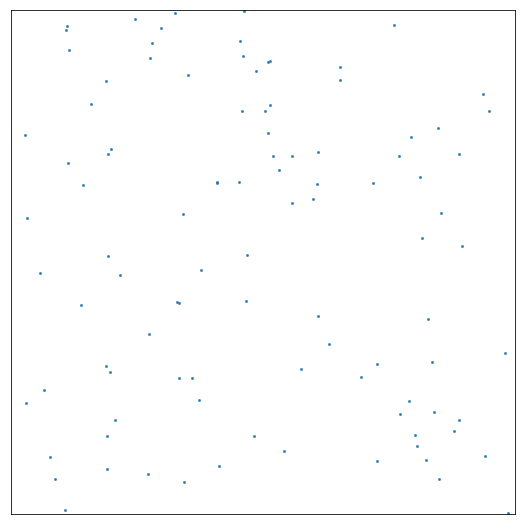

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import itertools
from matplotlib import rc
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = u'/usr/bin/ffmpeg'
import timeit

nbpart = 100
def merge(x,y):
    i = 0
    ret = []
    while i < len(x):
        ret.append(x[i])
        ret.append(y[i])
        i = i + 1
    return ret   

@jit
def split_coordinates(x):
    px = []
    py = []
    for i in range(len(x)):
        if (i % 2) == 0:
            px.append(x[i])
        else:
            py.append(x[i])
            
    return (px,py)

px = []
py = []
while len(px) < nbpart:
    x = np.random.uniform(0.0, 3.0)
    y = np.random.uniform(0.0, 3.0)
    dlist = map(lambda p: (p[0]-x)**2 + (p[1]-y)**2, zip(px,py))
    if len(filter(lambda distance: distance < (10**-2)**2, dlist)) > 1:
        continue
    else:
        px.append(x)
        py.append(y)
        
v = [np.random.uniform(0.0, 0.1) for _ in range(nbpart*2)]
a = [np.random.uniform(0.0, 9.81) for _ in range(nbpart*2)]
x = list(itertools.chain.from_iterable(zip(px,py)))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=True)
ax.set_xlim(0, 3), ax.set_xticks([])
ax.set_ylim(0, 3), ax.set_yticks([])

scat = ax.scatter(px, py, s=5, lw=0.5)

leapfrog1(10**-4.0, x, v, a)

apply_reflect(x, v, a, 2.9999999)

compute_forces(x, a, G=0.0, eps=1.0, sig=10**-2)

leapfrog2(10**-4.0, v, a)

def update(frame_number):
    for _ in range(100):
        leapfrog1(10**(-4.0), x, v, a)
        apply_reflect(x, v, a, 2.9999999)
        compute_forces(x, a, G=0.0, eps=1.0, sig=10**-2)
        leapfrog2(10**(-4.0), v, a)
        px, py = split_coordinates(x)
    
    scat.set_offsets( zip(px,py) )
    
animation = FuncAnimation(fig, update, interval=5, frames=9000)
rc('animation', html='html5')
animation


In [ ]:

fig, ax = plt.subplots()    

data = np.cumsum(np.random.normal(size=100)) #some list of data

ax.grid()
sc = ax.scatter(data[::2], data[1::2], c=data[1::2])

def plot(a, data):
    data += np.cumsum(np.random.normal(size=100)+3e-2)
    X = np.c_[data[::2], data[1::2]]
    sc.set_offsets(X)
    # manually relim:
    xmin=X[:,0].min(); xmax=X[:,0].max()
    ymin=X[:,1].min(); ymax=X[:,1].max()
    ax.set_xlim(xmin-0.1*(xmax-xmin),xmax+0.1*(xmax-xmin))
    ax.set_ylim(ymin-0.1*(ymax-ymin),ymax+0.1*(ymax-ymin))

ani = matplotlib.animation.FuncAnimation(fig, plot, fargs=(data,),
            frames=1000, interval=100, repeat=True) 
plt.show()
rc('animation', html='html5')
ani